System to predict identity of a given face .
It implements the following:
1. MTCNN - face detection
2. FaceNet - create a face embedding for each detected face
3. Linear Support Vector Machine - classifier to predict identity of a given face

Dataset: 5 Celebrity Faces Dataset, Kaggle https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset
Data has a range of orientations, lighting, and in various sizes, basis for our classifier, trained on the ‘train‘ dataset only and classify faces in the ‘val‘ dataset.

In [1]:
# stop warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Detect Face

Detect the face in each photo and reduce the dataset to a series of faces only.

In [2]:
# face detection
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# extract a single face from given photo
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


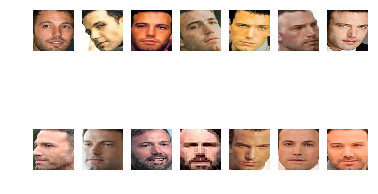

In [3]:
# specify the folder to plot
folder = '5-celebrity-faces-dataset/train/ben_afflek/'
i = 1

# enumarate files
for filename in listdir(folder):
    
    path = folder + filename
    
    # get face
    face = extract_face(path)
    print(i, face.shape)
    
    # plot
    pyplot.subplot(2, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

In [4]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    
    faces = list()
    
    # enumarate files
    for filename in listdir(directory):
        
        path = directory + filename
        
        # get face
        face = extract_face(path)
        
        # store
        faces.append(face)
        
    return faces

In [5]:
'''
Load a dataset that contains one subdir for each
class that it contains
'''
from os.path import isdir

def load_dataset(directory):
    
    X, y = list(), list()
    
    # enumarate folders, one per class
    for subdir in listdir(directory):
        
        path = directory + subdir + '/'
        
        # skip any files that might be in the subdir
        if not isdir(path):
            continue
        
        # load all faces in the subdir
        faces = load_faces(path)
        
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('\n>loaded %d examples for class: %s' % (len(faces), subdir))
        
        # store
        X.extend(faces)
        y.extend(labels)
        
    return asarray(X), asarray(y)

In [6]:
# load train dataset
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print('Training data shape: ',trainX.shape, trainy.shape)

# load test dataset
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
print('Test data shape: ', testX.shape, testy.shape)

from numpy import savez_compressed

# save the arrays to file
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)


>loaded 14 examples for class: ben_afflek

>loaded 17 examples for class: elton_john

>loaded 22 examples for class: mindy_kaling

>loaded 19 examples for class: madonna

>loaded 21 examples for class: jerry_seinfeld
Training data shape:  (93, 160, 160, 3) (93,)

>loaded 5 examples for class: ben_afflek

>loaded 5 examples for class: elton_john

>loaded 5 examples for class: mindy_kaling

>loaded 5 examples for class: madonna

>loaded 5 examples for class: jerry_seinfeld
Test data shape:  (25, 160, 160, 3) (25,)


### 2. Create Face Embeddings

Face Embedding - vector representing features extracted from the face.
Can be compared with vectors generated for other faces, i.e another vector that is close (by some measure) may be the same person, whereas another vector that is far (by some measure) may be a different person.
classifier will take a face embedding as input and predict the identity of the face.
FaceNet model to pre-process a face to create a face embedding that can be stored and used as input to our classifier model. 

In [13]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
(93, 128)
(25, 128)


Download pretrained model from https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn

### Perform Face Classification

In [14]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


### Plotting the Original Face and Prediction